In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Statistical modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# Load cleaned dataset for frequency modelling
df = pd.read_csv("../data/data2_cleaned.csv")

# Preview data
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,1,1,1,1,1,0,1,1,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,0,1,1,1,1,1,1,1,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,1,1,1,1,1,0,1,1,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,0,0,0,1,0,0,0,1,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,0,1,1,1,0,0,1,1,5,0


In [3]:
#Check if claim_status is already a count variable
print("Unique values in claim_status:", df['claim_status'].unique())
print("Value counts of claim_status:\n", df['claim_status'].value_counts())

#Check for overdispersion
mean_claims = df['claim_status'].mean()
var_claims = df['claim_status'].var()
dispersion = var_claims / mean_claims
print(f"\nMean of claim_status: {mean_claims:.4f}")
print(f"Variance of claim_status: {var_claims:.4f}")
print(f"Dispersion ratio (variance/mean): {dispersion:.4f}")
print("Overdispersion exists if ratio > 1")

Unique values in claim_status: [0 1]
Value counts of claim_status:
 claim_status
0    54844
1     3748
Name: count, dtype: int64

Mean of claim_status: 0.0640
Variance of claim_status: 0.0599
Dispersion ratio (variance/mean): 0.9360
Overdispersion exists if ratio > 1


In [4]:
#Prepare data - select relevant features
features = ['customer_age', 'vehicle_age', 'region_density', 'airbags', 
           'is_esc', 'ncap_rating', 'subscription_length']

#Formula for statsmodels
formula = "claim_status ~ " + " + ".join(features)

#Split data into train and test
np.random.seed(42)
mask = np.random.rand(len(df)) < 0.8
train_df = df[mask]
test_df = df[~mask]

#Fit Poisson Regression using formula API
poisson_model = smf.glm(formula=formula, data=train_df, family=sm.families.Poisson()).fit()
print("\nPoisson Regression Summary:")
print(poisson_model.summary())

# Fit Negative Binomial Regression using formula API
nb_model = smf.glm(formula=formula, data=train_df, family=sm.families.NegativeBinomial()).fit()
print("\nNegative Binomial Regression Summary:")
print(nb_model.summary())


Poisson Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_status   No. Observations:                46938
Model:                            GLM   Df Residuals:                    46930
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11158.
Date:                Mon, 16 Feb 2026   Deviance:                       16255.
Time:                        10:17:01   Pearson chi2:                 4.37e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.007528
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

C:\Users\Trevor\Downloads\Anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [5]:
# Make predictions
poisson_predictions = poisson_model.predict(test_df)
nb_predictions = nb_model.predict(test_df)

# Calculate metrics
def calculate_metrics(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(mse)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

poisson_metrics = calculate_metrics(test_df['claim_status'], poisson_predictions)
nb_metrics = calculate_metrics(test_df['claim_status'], nb_predictions)

# Compare models
print("\nModel Comparison:")
print(f"Poisson - MSE: {poisson_metrics['MSE']:.4f}, MAE: {poisson_metrics['MAE']:.4f}, RMSE: {poisson_metrics['RMSE']:.4f}")
print(f"Negative Binomial - MSE: {nb_metrics['MSE']:.4f}, MAE: {nb_metrics['MAE']:.4f}, RMSE: {nb_metrics['RMSE']:.4f}")
print(f"Poisson AIC: {poisson_model.aic:.2f}, BIC: {poisson_model.bic:.2f}")
print(f"Negative Binomial AIC: {nb_model.aic:.2f}, BIC: {nb_model.bic:.2f}")



Model Comparison:
Poisson - MSE: 0.0572, MAE: 0.1169, RMSE: 0.2392
Negative Binomial - MSE: 0.0572, MAE: 0.1169, RMSE: 0.2392
Poisson AIC: 22332.79, BIC: -488551.64
Negative Binomial AIC: 22545.11, BIC: -490681.04


C:\Users\Trevor\Downloads\Anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


C:\Users\Trevor\AppData\Local\Temp\ipykernel_6016\3109058983.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_claim_freq = df.groupby('age_group')['claim_status'].mean()
C:\Users\Trevor\AppData\Local\Temp\ipykernel_6016\3109058983.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_claim_count = df.groupby('age_group')['claim_status'].sum()


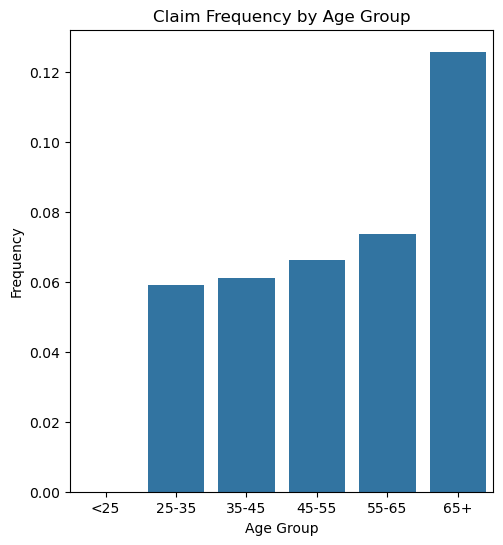

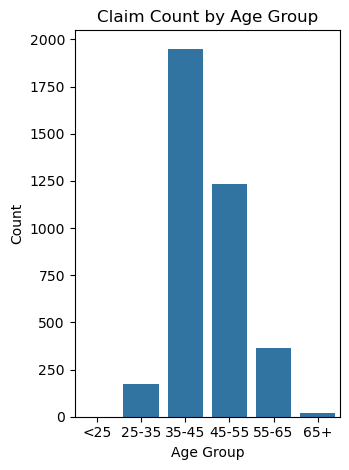

C:\Users\Trevor\AppData\Local\Temp\ipykernel_6016\3109058983.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehicle_claim_freq = df.groupby('vehicle_age_group')['claim_status'].mean()


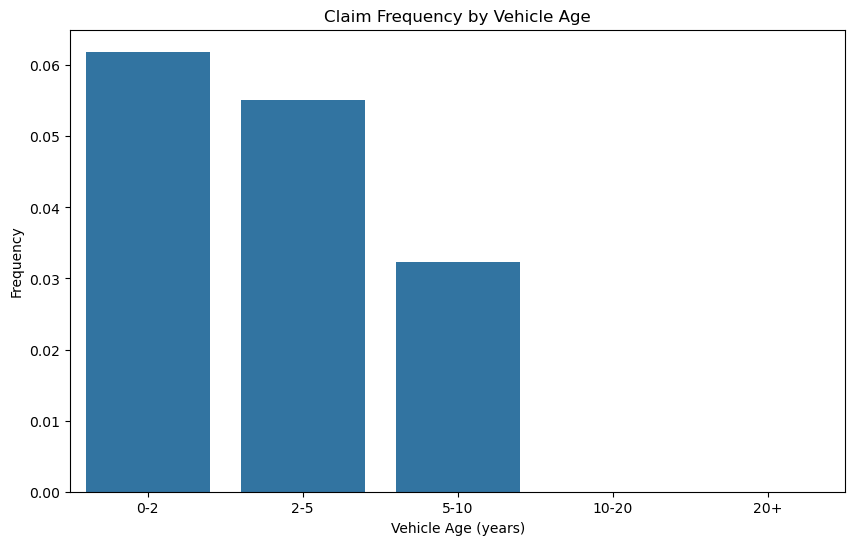

In [9]:
# Group data by customer_age and analyze claim frequency
df['age_group'] = pd.cut(df['customer_age'], bins=[0, 25, 35, 45, 55, 65, 100], 
                         labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])
age_claim_freq = df.groupby('age_group')['claim_status'].mean()
age_claim_count = df.groupby('age_group')['claim_status'].sum()

# Visualize claim frequency by age group
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=age_claim_freq.index, y=age_claim_freq.values)
plt.title('Claim Frequency by Age Group')
plt.ylabel('Frequency')
plt.xlabel('Age Group')
plt.savefig("../plots/claim_frequency_by_age.png", dpi=300)
plt.show()

#visualize claim count by age group
plt.subplot(1, 2, 2)
sns.barplot(x=age_claim_count.index, y=age_claim_count.values)
plt.title('Claim Count by Age Group')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.tight_layout()
plt.savefig("../plots/claim_count_by_age.png", dpi=300)
plt.show()


#visualization grouped by vehicle_age
df['vehicle_age_group'] = pd.cut(df['vehicle_age'], bins=[0, 2, 5, 10, 20, 100], 
                                labels=['0-2', '2-5', '5-10', '10-20', '20+'])
vehicle_claim_freq = df.groupby('vehicle_age_group')['claim_status'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=vehicle_claim_freq.index, y=vehicle_claim_freq.values)
plt.title('Claim Frequency by Vehicle Age')
plt.ylabel('Frequency')
plt.xlabel('Vehicle Age (years)')
plt.savefig("../plots/claim_frequency_by_vehicle_age.png", dpi=300)
plt.show()

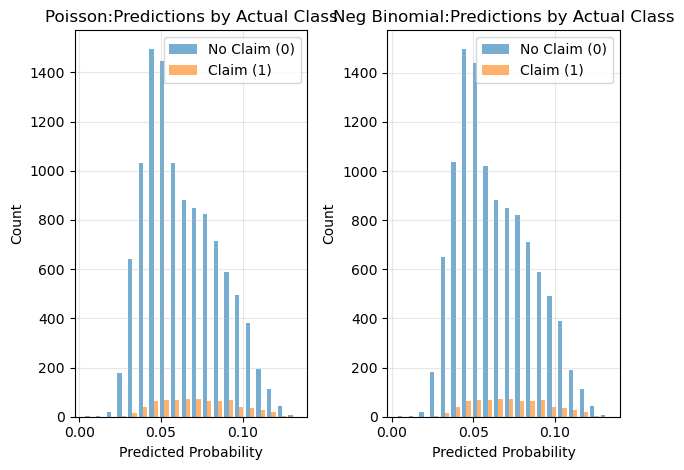

In [10]:
#Model's predicted values
# Poisson predictions
plt.subplot(1, 2, 1)
plt.hist([poisson_predictions[test_df['claim_status']==0], 
          poisson_predictions[test_df['claim_status']==1]], 
         bins=20, label=['No Claim (0)', 'Claim (1)'], alpha=0.6)
plt.title('Poisson:Predictions by Actual Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../plots/poisson_predictions.png", dpi=300)

# Negative Binomial predictions
plt.subplot(1, 2, 2)
plt.hist([nb_predictions[test_df['claim_status']==0], 
          nb_predictions[test_df['claim_status']==1]], 
         bins=20, label=['No Claim (0)', 'Claim (1)'], alpha=0.6)
plt.title('Neg Binomial:Predictions by Actual Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/negative_binomial_predictions.png", dpi=300)
plt.show()